In [1]:
%load_ext autoreload
%autoreload 2
import sys, os
import numpy as np
import scipy.optimize as optimize
import scipy.linalg as linalg
from scipy.stats import linregress

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

/home/jean/miniconda3/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jean/miniconda3/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
def getPhiMatrices(w, times):
    phi = []
    for i in times:
        phi.append(np.array([np.sin(2*np.pi*w*i), np.cos(2*np.pi*w*i)]))
    phi = np.array(phi)
    phi_plus = linalg.pinv(phi)
    return np.array(phi), np.array(phi_plus)


def least_sqVP(y, times, w):
    phi, phi_plus = getPhiMatrices(w, times)
    return np.sum( (y - np.matmul(phi, np.matmul(phi_plus, y)))**2 )

def fitfunc(times, *para):
    return para[0]*np.sin(2*np.pi*para[2]*times) + para[1]*np.cos(2*np.pi*para[2]*times)

In [23]:
fitVPFreq = []
fitVPNormS = []
fitVPNormC = []
res2VP = []

fitLSFreq = []
fitLSNormS = []
fitLSNormC = []
res2LS = []

freq_init_arr = []

# Parameters for MC
freq = 0.324
normS = 2.023
normC = -0.7
time=True
for i in range(10):
    freq_init = 0.32
    freq_init_arr.append(freq_init)
    # Make MC
    
    dt = 1e-2
    times = np.arange(0, 10, dt)
    data = normS*np.sin(2*np.pi*freq*times) + normC*np.sin(2*np.pi*freq*times) + np.random.normal(0, 1e-2, size=len(times))

    # Run variable projection fit
    if i == 0 and time:
        print("Variable Projection")
        %timeit fit_freq = optimize.leastsq( lambda args: least_sqVP(data, times, *args), x0=[freq_init], full_output=1, ftol=1e-15, gtol=1e-15, xtol=1e-15 )[0][0]; \
        fit = optimize.leastsq( lambda args: (data - fitfunc(times, args[0], args[1], fit_freq)), x0=[0.5, 0.5], full_output=1, ftol=1e-15, gtol=1e-15, xtol=1e-15 )[0]

    fit_freq = optimize.leastsq( lambda args: least_sqVP(data, times, *args), x0=[freq_init], full_output=1, ftol=1e-15, gtol=1e-15, xtol=1e-15 )[0][0]
    fit = optimize.leastsq( lambda args: (data - fitfunc(times, args[0], args[1], fit_freq)), x0=[0.5, 0.5], full_output=1, ftol=1e-15, gtol=1e-15, xtol=1e-15 )[0]     
    
    fitVPNormS.append(fit[0])
    fitVPNormC.append(fit[1])
    fitVPFreq.append(fit_freq)
    res2VP.append(np.sum((data - fitfunc(times, fitVPNormS[-1], fitVPNormC[-1], fitVPFreq[-1]))**2))
    
    # Run fit with normal least squares
    if i == 0 and time:
        print("Least Squares")
        %timeit fit = optimize.leastsq( lambda args: (data-fitfunc(times, args[0], args[1], freq_init)), x0=[0.5, 0.5], full_output=1, ftol=1e-15, gtol=1e-15, xtol=1e-15 )[0]; \
        fit = optimize.leastsq( lambda args: (data-fitfunc(times, *args)), x0=[fit[0], fit[1], freq_init], full_output=1, ftol=1e-15, gtol=1e-15, xtol=1e-15 )[0]
        
    fit = optimize.leastsq( lambda args: (data-fitfunc(times, args[0], args[1], freq_init)), x0=[0.5,0.5], full_output=1, ftol=1e-15, gtol=1e-15, xtol=1e-15 )[0]
    fit = optimize.leastsq( lambda args: (data-fitfunc(times, *args)), x0=[fit[0], fit[1], freq_init], full_output=1, ftol=1e-15, gtol=1e-15, xtol=1e-15 )[0]
    
    fitLSNormS.append(fit[0])
    fitLSNormC.append(fit[1])
    fitLSFreq.append(fit[2])
    res2LS.append(np.sum((data - fitfunc(times, fitLSNormS[-1], fitLSNormC[-1], fitLSFreq[-1]))**2))

fitVPFreq = np.array(fitVPFreq).flatten()
fitVPNormS = np.array(fitVPNormS).flatten()
fitVPNormC = np.array(fitVPNormC).flatten()
res2VP = np.array(res2VP).flatten()
fitLSFreq = np.array(fitLSFreq).flatten()
fitLSNormS = np.array(fitLSNormS).flatten()
fitLSNormC = np.array(fitLSNormC).flatten()
res2LS = np.array(res2LS).flatten()
freq_init_arr = np.array(freq_init)

Variable Projection
794 ms ± 28.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Least Squares
4.63 ms ± 223 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


For dt=1e-2, times = np.arange(0, 50, dt):

Variable Projection  
15.7 s ± 1.22 s per loop (mean ± std. dev. of 7 runs, 1 loop each)  
Least Squares  
45.7 ms ± 165 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)  

For dt=1e-3, times = np.arange(0, 50, dt): memory error (as expected)

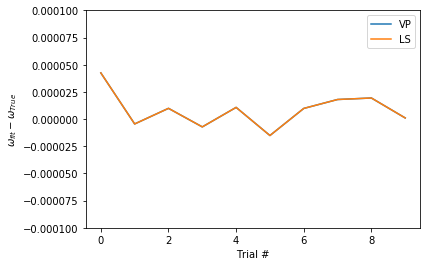

In [36]:
plt.plot(fitVPFreq-freq, label="VP")
plt.plot(fitLSFreq-freq, label="LS")
plt.plot(freq_init_arr-freq)
plt.ylabel("$\omega_{fit}-\omega_{True}$")
plt.ylim(-1e-4, 1e-4)
plt.xlabel("Trial #")
plt.legend()
plt.show()

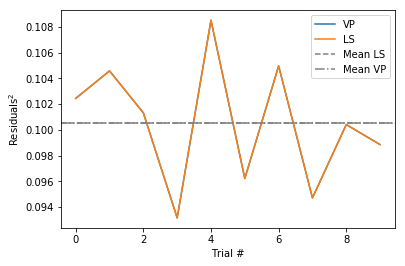

In [25]:
plt.plot(res2VP, label="VP")
plt.plot(res2LS, label="LS")
plt.axhline(np.mean(res2LS), ls="--", c="grey", label="Mean LS")
plt.axhline(np.mean(res2VP), ls="-.", c="grey", label="Mean VP")
plt.ylabel("Residuals$^2$")
plt.xlabel("Trial #")
plt.legend()
plt.show()